Script for testing different density estimation methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# custom libs
import sys
sys.path.append("..")
from src.dynamicFPC import K_dFPC, W_dFPC
from src.transformations import mLQDT, obtain_densities_from_lqd
from src.forecasting import overall_measures
from src.preprocessing import weigh_norm_densities, align_densities

from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.neighbors import KernelDensity

DPI: https://neuropsychology.github.io/NeuroKit/functions/stats.html#neurokit2.stats.density_bandwidth

# Functions

In [17]:
# Complete workflow
def lqdT_estimateL2_invT(densities, densities_supports):
    bovespa_mLQDT = mLQDT(
                    densities,
                    densities_supports
                )
    bovespa_mLQDT.densities_to_lqdensities(verbose=False)
    df_lqds = bovespa_mLQDT.lqd.iloc[1:-1,:]
    df_lqds_support = bovespa_mLQDT.lqd_support[1:-1]

    KdFPC_kwargs = {
        "lag_max": 5,
        "alpha": 0.10,
        "du": 0.1,
        "B": 1000,
        "p": 5,
        "m": df_lqds.shape[0],
        "u": df_lqds_support,
        "select_ncomp": False,
        "dimension": 2
    }

    KdFPC_model = K_dFPC(df_lqds.values)
    KdFPC_model.fit(**KdFPC_kwargs)
    df_yhat = pd.DataFrame(KdFPC_model.fitted_values, columns = df_lqds.columns)
    kle_bkw_supports, kle_bkw_densities = obtain_densities_from_lqd(
                                                                df_yhat,
                                                                bovespa_mLQDT.lqd_support,
                                                                bovespa_mLQDT.c,
                                                                verbose=False
                                                                )
        
    df_supp, df_density_observed, df_density_estimated = align_densities(
                                                            densities_supports, 
                                                            densities, 
                                                            kle_bkw_supports, 
                                                            kle_bkw_densities, 
                                                            kle_bkw_densities.columns)
    
    accuracy_measures = overall_measures(test=df_density_observed.copy(), forecast=df_density_estimated.copy())
    
    return df_supp, df_density_observed, df_density_estimated, accuracy_measures


# KDE

In [18]:
# Dados
data_path = "../data/processed/"
returns_path = ''.join([data_path, 'ibovespa_treated.xlsx'])
df = pd.read_excel(returns_path, index_col="time")
df.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-11-14,2025-11-17,2025-11-18,2025-11-19,2025-11-21,2025-11-24,2025-11-25,2025-11-26,2025-11-27,2025-11-28
time,,,,,,,,,,,,,,,,,,,,,
10:00:00,0.000011,-0.000372,-0.000035,0.007233,-0.001305,-0.000459,0.002388,0.002212,-0.008001,-0.000824,...,-0.000957,-0.002307,-0.003734,-0.005020,-0.001139,-0.000255,0.002339,0.004176,-0.000224,-0.000238
10:05:00,-0.002271,0.003372,0.001716,0.005538,0.000069,0.006429,0.002343,0.001918,-0.007582,-0.000413,...,-0.001522,0.000739,-0.000613,0.000306,-0.002021,-0.000810,0.001557,-0.001565,-0.000193,0.002906
10:10:00,-0.000582,0.002832,-0.000502,0.000739,0.000261,0.001891,0.000775,-0.001172,0.000216,-0.000432,...,0.000360,-0.000105,-0.000159,-0.000362,0.000092,0.001131,0.001170,0.000202,0.000556,0.000475
10:15:00,-0.001997,0.001091,0.000111,-0.000192,0.000407,-0.001392,-0.000477,-0.001526,0.000198,-0.001821,...,0.001121,-0.000284,0.003272,-0.001107,-0.001012,-0.000174,0.001002,0.001815,-0.000168,0.000973
10:20:00,-0.000037,-0.000505,-0.000327,-0.000580,-0.000436,-0.000405,0.001263,0.000676,-0.002667,0.001033,...,0.000449,0.000335,0.000853,0.000981,-0.000057,-0.000096,0.000832,0.001951,0.001060,-0.001004


In [15]:
m = 256
x_grid = np.linspace(df.min().min(), df.max().max(), 256)

## Gaussian + Weighted

<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
C:\Users\user\AppData\Local\Temp\ipykernel_23188\1955582349.py:17: SyntaxWarning: invalid escape sequence '\h'
  df_density.plot(ax=ax[0], legend=False, color="#06d6a0", alpha=.2, title="$\hat{f}$")


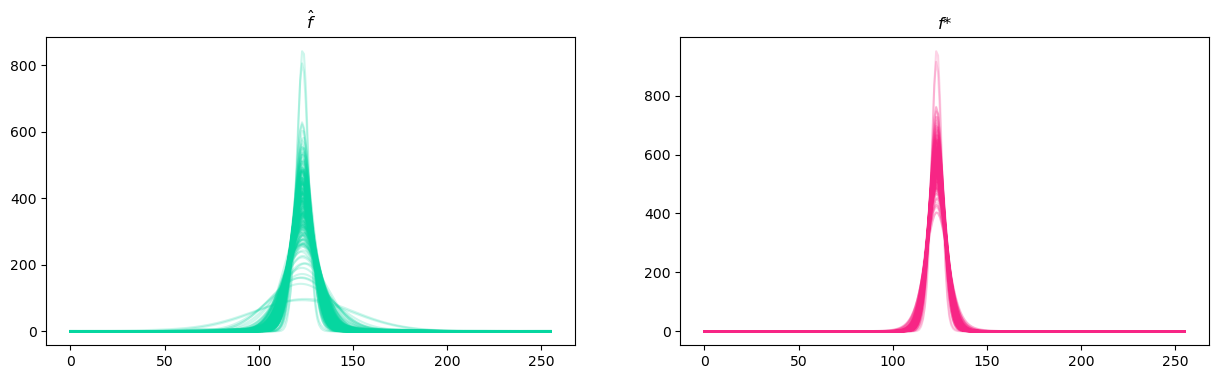

In [ ]:
bandwidth = 1.0

l = []
for t in df.columns:
    kde = gaussian_kde(df[t], bw_method=bandwidth)
    l.append(pd.Series(kde(x_grid)))

df_density = pd.concat(l, axis=1)
df_density.columns = df.columns
df_supports = pd.concat([pd.Series(x_grid) for r in range(len(df.columns))], axis=1)
df_supports.columns = df.columns
df_density_2 = weigh_norm_densities(df_density, x_grid)

# PLOT
fig, ax = plt.subplots(1, 2, figsize=(15, 4))  
df_density.plot(ax=ax[0], legend=False, color="#06d6a0", alpha=.2, title="$\hat{f}$")
df_density_2.plot(ax=ax[1], legend=False, color="#f72585", alpha=.2, title = "$f{*}$")

plt.show()

In [19]:
df_supp, df_density_observed, df_density_estimated, accuracy_measures = lqdT_estimateL2_invT(df_density, df_supports)
accuracy_measures

c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\scipy\interpolate\_interpolate.py:497: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\scipy\interpolate\_interpolate.py:500: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


{'KLD': np.float64(0.093423),
 'JSD': np.float64(0.53107),
 'Lnorm': np.float64(0.002651)}

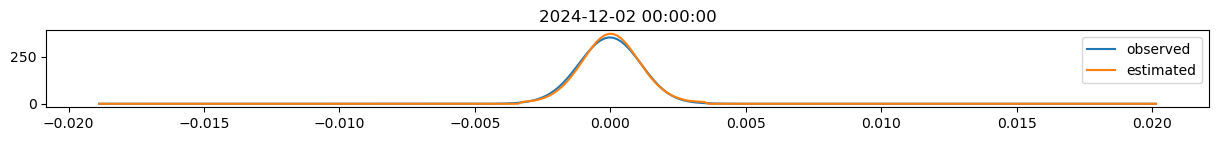

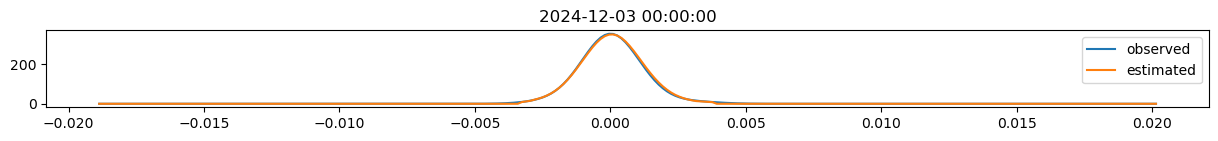

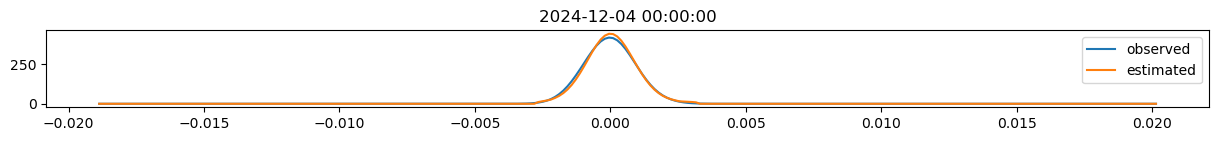

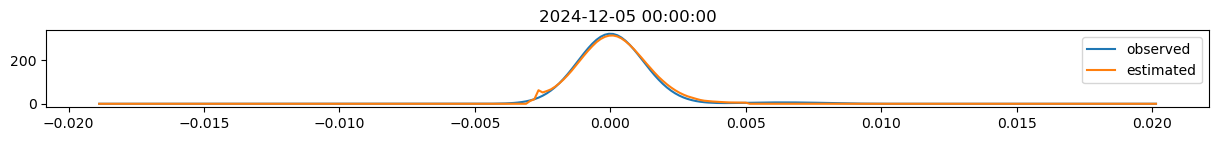

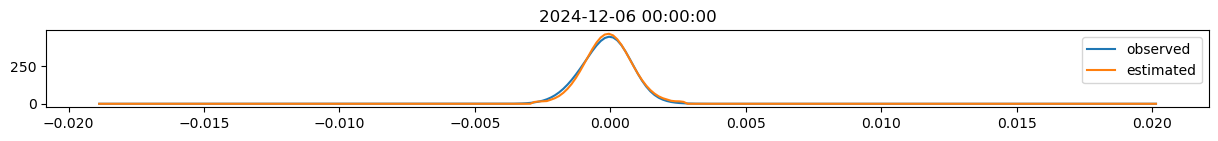

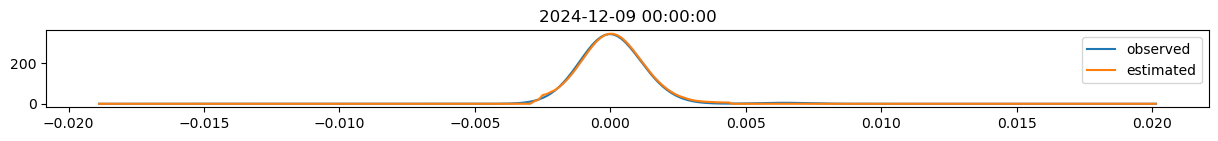

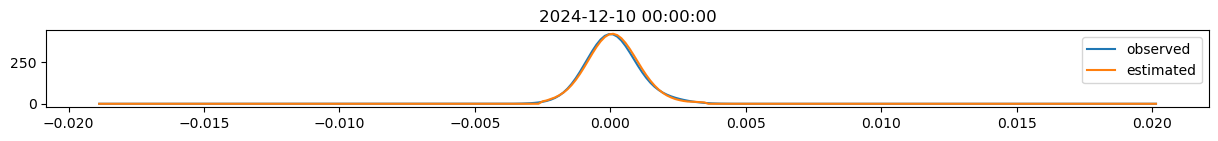

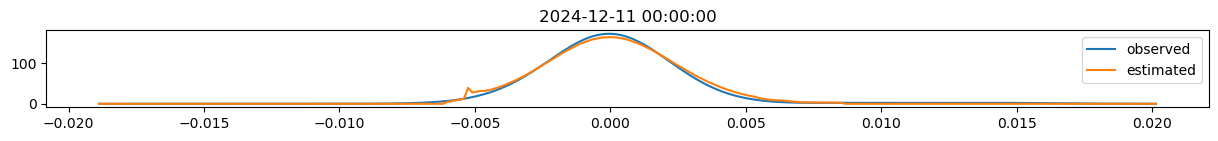

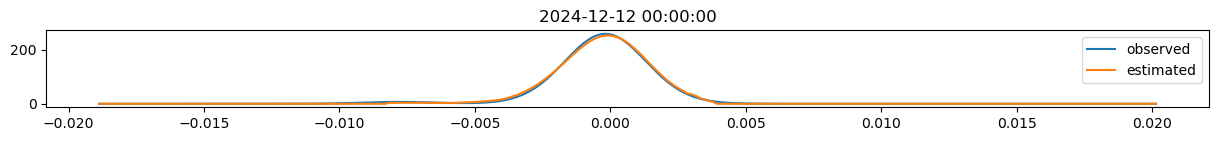

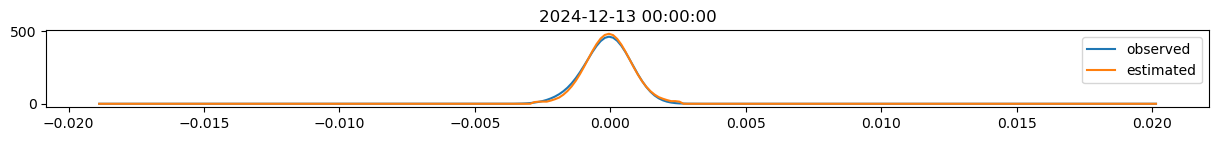

In [23]:
for i in range(10):
    t = df.columns[i]
    plt.figure(figsize=(15,1))
    plt.plot(df_supp[t], df_density_observed[t], label="observed")
    plt.plot(df_supp[t], df_density_estimated[t], label="estimated")
    plt.legend()
    plt.title(f"{t}")
    plt.show()

In [24]:
df_supp, df_density_observed, df_density_estimated, accuracy_measures = lqdT_estimateL2_invT(df_density_2, df_supports)
accuracy_measures

{'KLD': np.float64(0.079043),
 'JSD': np.float64(0.429685),
 'Lnorm': np.float64(0.003591)}

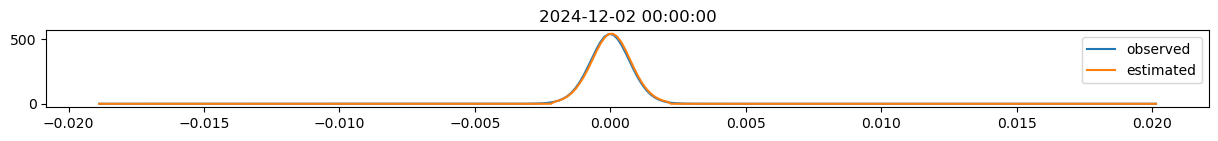

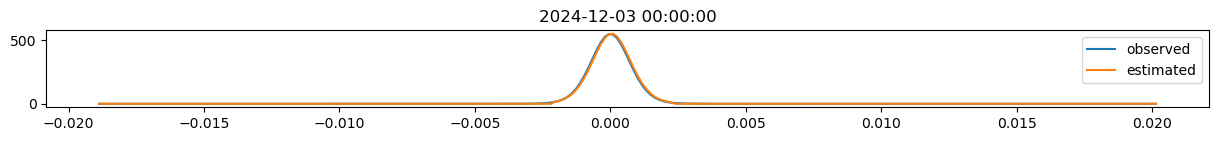

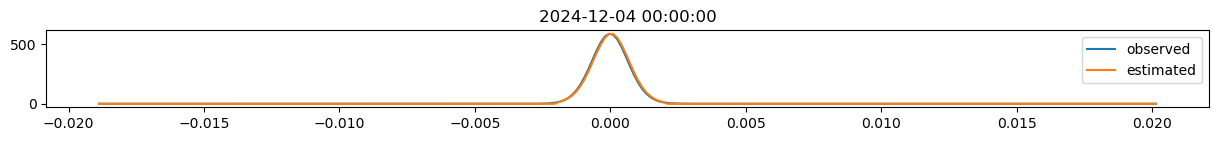

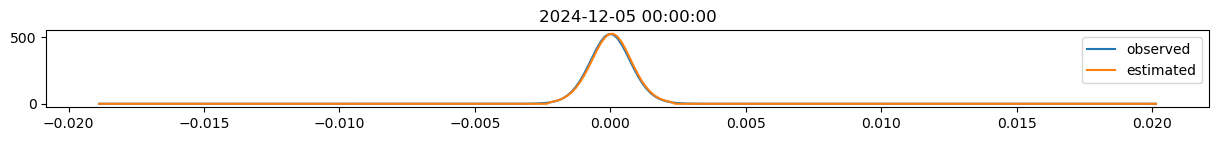

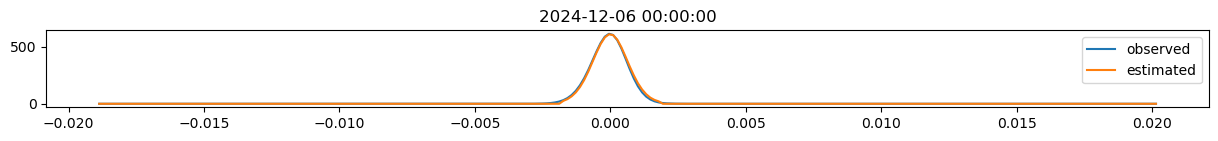

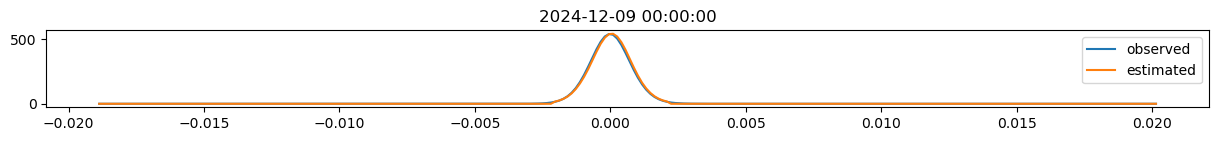

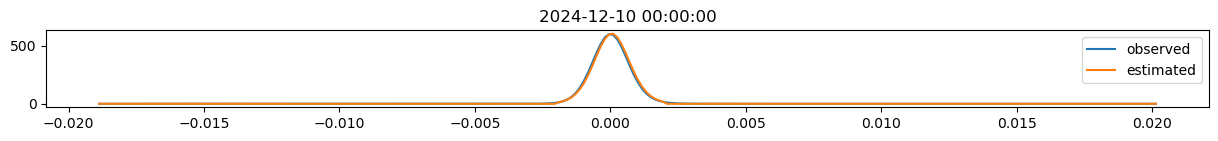

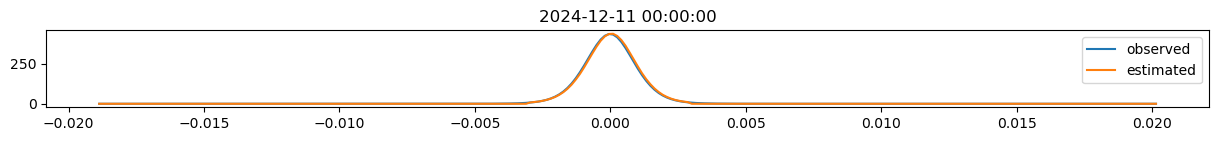

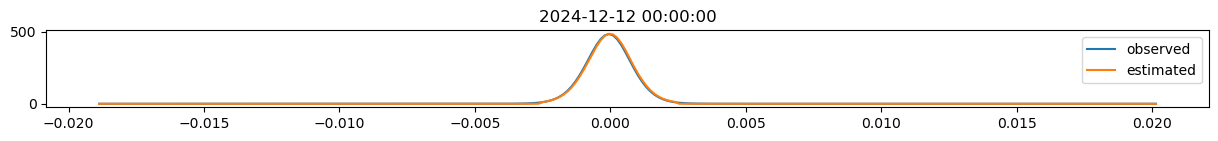

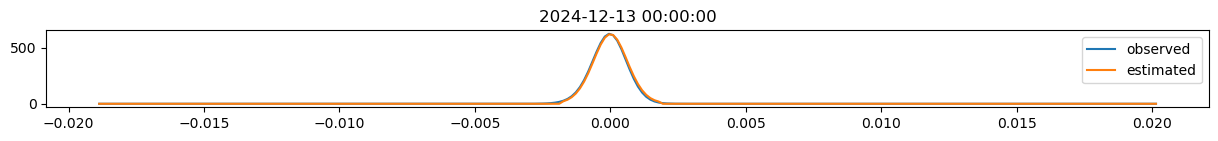

In [25]:
for i in range(10):
    t = df.columns[i]
    plt.figure(figsize=(15,1))
    plt.plot(df_supp[t], df_density_observed[t], label="observed")
    plt.plot(df_supp[t], df_density_estimated[t], label="estimated")
    plt.legend()
    plt.title(f"{t}")
    plt.show()

In [ ]:
# sk_kernels = [
#     "gaussian",
#     # "tophat",
#     "epanechnikov",
#     # "exponential",
#     # "linear",
#     # "cosine",
# ]
# l=[]

# i = 5
# t = df.columns[i]
# for kernel in sk_kernels:
#     kde = KernelDensity(bandwidth = 0.002, kernel=kernel)
#     data = df.loc[:,t].values.reshape(-1,1)
#     kde.fit(data)
#     log_densities = kde.score_samples(x_grid.reshape(-1,1))
#     densities = np.exp(log_densities)
#     l.append(pd.Series(densities))

# df_densities_kernels = pd.concat(l, axis=1)
# df_densities_kernels.columns = sk_kernels


# plt.figure()
# for kernel in df_densities_kernels.columns:
    
#     plt.plot(x_grid, df_densities_kernels.loc[:,kernel], label=kernel, alpha=.5)

# plt.legend()
# plt.show()

## Gaussian + Varying bandwidth + Weighted

<>:21: SyntaxWarning: invalid escape sequence '\h'
<>:21: SyntaxWarning: invalid escape sequence '\h'
C:\Users\user\AppData\Local\Temp\ipykernel_23188\3224800896.py:21: SyntaxWarning: invalid escape sequence '\h'
  df_density.plot(ax=ax[0], legend=False, color="#06d6a0", alpha=.2, title="$\hat{f}$")


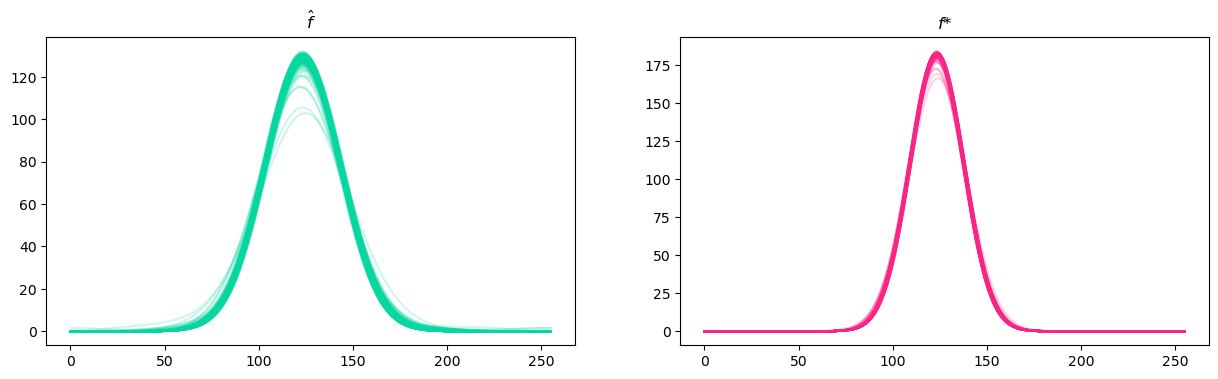

In [ ]:
kernel = 'gaussian'
bandwidth = 0.003

l = []
for t in df.columns:
    kde = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    data = df.loc[:,t].values.reshape(-1,1)
    kde.fit(data)
    log_densities = kde.score_samples(x_grid.reshape(-1,1))
    densities = np.exp(log_densities)
    l.append(pd.Series(densities))

df_density = pd.concat(l, axis=1)
df_density.columns = df.columns
df_supports = pd.concat([pd.Series(x_grid) for r in range(len(df.columns))], axis=1)
df_supports.columns = df.columns

df_density_2 = weigh_norm_densities(df_density, x_grid)

# PLOT
fig, ax = plt.subplots(1, 2, figsize=(15, 4))  
df_density.plot(ax=ax[0], legend=False, color="#06d6a0", alpha=.2, title="$\hat{f}$")
df_density_2.plot(ax=ax[1], legend=False, color="#f72585", alpha=.2, title = "$f{*}$")

plt.show()

In [29]:
df_supp, df_density_observed, df_density_estimated, accuracy_measures = lqdT_estimateL2_invT(df_density, df_supports)
accuracy_measures

{'KLD': np.float64(0.074438),
 'JSD': np.float64(0.187042),
 'Lnorm': np.float64(0.000542)}

In [30]:
df_supp, df_density_observed, df_density_estimated, accuracy_measures = lqdT_estimateL2_invT(df_density_2, df_supports)
accuracy_measures

{'KLD': np.float64(0.076417),
 'JSD': np.float64(0.236085),
 'Lnorm': np.float64(0.000748)}

# Tests

In [ ]:
bovespa_mLQDT = mLQDT(
                df_density,
                df_supports
            )
bovespa_mLQDT.densities_to_lqdensities(verbose=False)

cut = 1 # LQDT has boundary problems
df_lqds = bovespa_mLQDT.lqd.iloc[cut:-cut,:]
df_lqds_support = bovespa_mLQDT.lqd_support[cut:-cut]

# df_lqds = bovespa_mLQDT.lqd
# df_lqds_support = bovespa_mLQDT.lqd_support

c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\scipy\interpolate\_interpolate.py:497: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\scipy\interpolate\_interpolate.py:500: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


<Axes: >

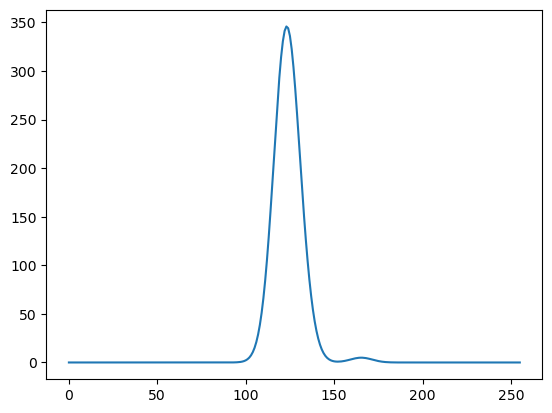

In [222]:
i = 5
col = df_lqds.columns[i]

df_density[col].plot()

<Axes: >

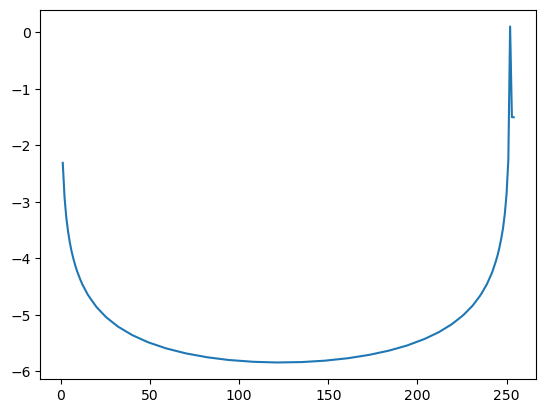

In [223]:
df_lqds[col].plot() # bumps on near the boundaries of support cause spikes on LQDT